2.6.0
Number of images: 262


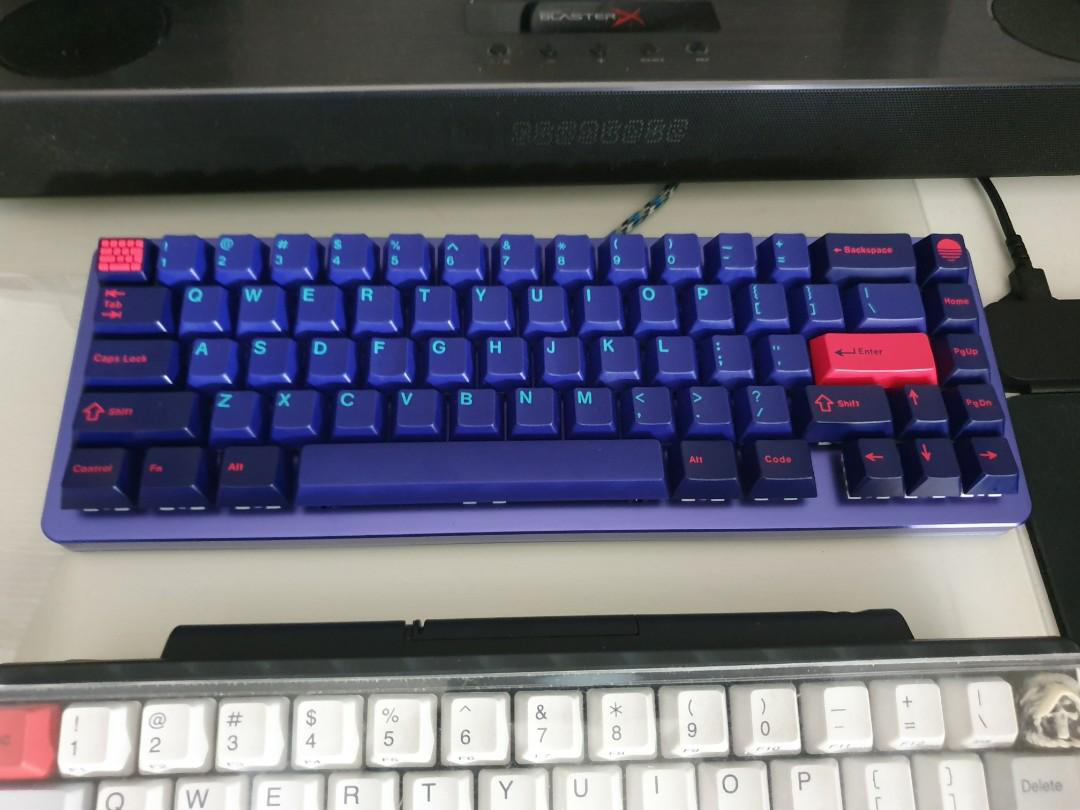

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

# download the dataset
import pathlib
data_dir = pathlib.Path("images/keycap_images/")

# .glob() returns an object of a list of files with the given syntax
# convert to a list to access that list
image_count = len(list(data_dir.glob("*/*")))

print (f"Number of images: {image_count}")


laser = list(data_dir.glob('laser/*'))
PIL.Image.open(str(laser[0]))


In [2]:
# create data sets with keycap images
batch_size = 32
img_height = 180
img_width = 180
# create training dataset
# training dataset alters the weights and biases of the model
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 262 files belonging to 6 classes.
Using 210 files for training.


In [3]:
# create validation dataset
# validation training set used at the end of each epoch to evaluate
# the accuracy of the model
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 262 files belonging to 6 classes.
Using 52 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['blue_samurai', 'carbon', 'chalk', 'laser', 'nautilus', 'red_samurai']


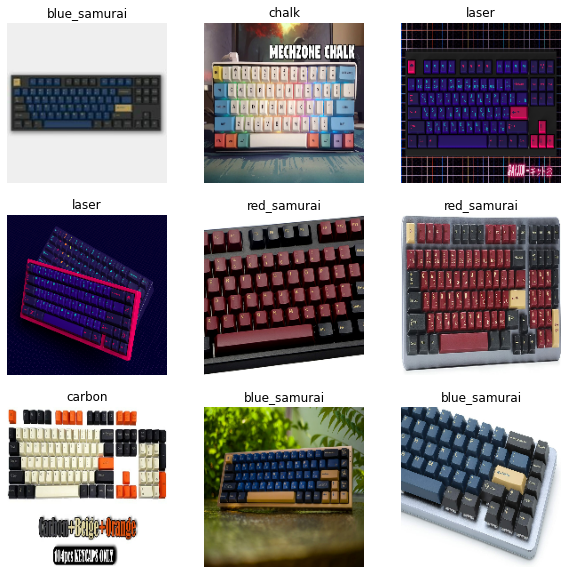

In [5]:
# visualizing the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# conditioning datasets for performance (prevent I/O blocking)
# Dataset.cache keeps images in memory after they're loaded during the first epoch
# Dataset.pregetch overlaps data preprocessing and model execucution during training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# standardize the [0,255] RGB values to [0,1] 
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [8]:
# Data Augmentation: taking the images from the training dataset and
# augmenting them (flip, rotate, zoom) to create new training images
# We create a new layer that augments those images

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

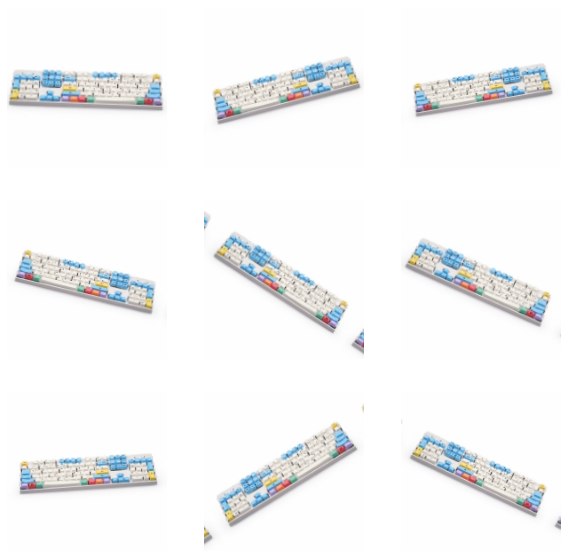

In [9]:
# Visualizing these newly generated images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
# new Sequential model that includes the augmentation layer and
# the dropout layer to prevent overfitting
num_classes = 6
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [12]:
# TRAINING THE UPDATED MODEL
# increase the number of epochs
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
7/7 [==============================] - 4s 468ms/step - loss: 2.0538 - accuracy: 0.1810 - val_loss: 1.7318 - val_accuracy: 0.2885
Epoch 2/15
7/7 [==============================] - 2s 338ms/step - loss: 1.6691 - accuracy: 0.2857 - val_loss: 1.5831 - val_accuracy: 0.4038
Epoch 3/15
7/7 [==============================] - 2s 339ms/step - loss: 1.4116 - accuracy: 0.4952 - val_loss: 1.3740 - val_accuracy: 0.4615
Epoch 4/15
7/7 [==============================] - 2s 358ms/step - loss: 1.0828 - accuracy: 0.6095 - val_loss: 1.1139 - val_accuracy: 0.5000
Epoch 5/15
7/7 [==============================] - 3s 373ms/step - loss: 0.7772 - accuracy: 0.7190 - val_loss: 0.7399 - val_accuracy: 0.6538
Epoch 6/15
7/7 [==============================] - 2s 371ms/step - loss: 0.6864 - accuracy: 0.7095 - val_loss: 1.0088 - val_accuracy: 0.6346
Epoch 7/15
7/7 [==============================] - 2s 326ms/step - loss: 0.6952 - accuracy: 0.7095 - val_loss: 0.8078 - val_accuracy: 0.7692
Epoch 8/15
7/7 [====

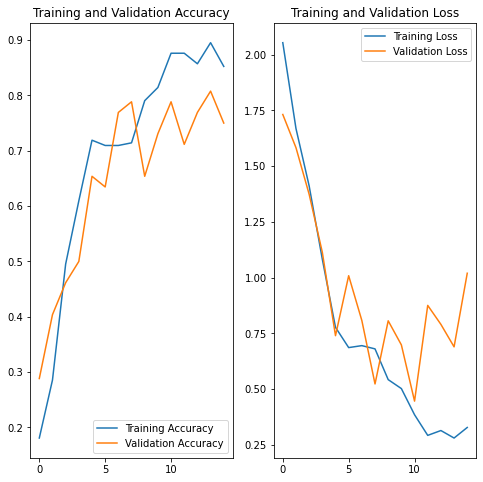

In [13]:
# plots of the loss and accurace on the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

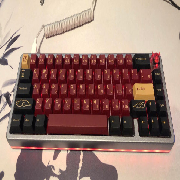

This image most likely belongs to red_samurai with a 99.90 percent confidence.


In [14]:
img = tf.keras.utils.load_img(
    'images/test/test.jpg', target_size=(img_height, img_width)
)
img.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
!mkdir -p saved_model
model.save("saved_model/")